# A Wright-Fisher simulation implemented in C++ via Cython.

This tutorial implements a Wright-Fisher simulation with mutation and recombination using [Cython](http://www.cython.org).  Cython is two things:

* A grammer/dialect of Python that allows static typing Python and of C/C++ types.
* A static compiler to turn the Cython grammer in to C or C++ code to compile into a Python extension module.

Cython has a learning curve of its own. A lot of what is shown below reflects best practices.  For those, we refer you to the [Cython documentation](https://cython.readthedocs.io/en/latest/).

Here, we avoid all use of [numpy](http://www.numpy.org) until we have to talk to [msprime](http://msprime.readthedocs.io).  We replace all numpy functionality with the equivalent routines from the C++11 standard library or the excellent GNU Scientific Library, or [GSL](https://www.gnu.org/software/gsl/doc/html/index.html). Yes, numpy is fast!  Numpy is written in C!  But, numpy has to talk back and forth to Python, meaning we can out-perform it by writing routines that execute completely on the C/C++ side.

This example is closer to reality for those working in lower-level languages.  First, we must build our world, which means defining data types (a C++ class in this case) and functions acting on those types.  After all that, we can code up the `simplify` and `evolve` functions. Such is the price of speed.

Here, we use C++ rather than C so that we don't have to worry about memory management and error handling.  Cython will nicely convert and C++ exception into a Python exception, meaning that one big `try/execept` block is sufficient to not leak memory for our `gsl_rng` object.

However, Cython does not allow *idiomatic* C++ to be written.  We do not have access to all C++11 syntax and concepts, nor do we have access to a fully const-correct grammar.  Cython is a "C first" tool, and the limited C++ support is simply a fact of life.

This example is conceptually idential to previous Python examples.  It does the following:

* Model mutations according to an infinitely-many sites scheme
* Model recombination as a uniform Poisson process
* Collect intermediate data during simulation and periodically simplify.

This tutorial results in a simulation fast enough to obtain many replicates, which allows us to compare the distribution of summary statistics to `msprime`.

First, we load an extension allowing us to write Cython in a notebook:

In [1]:
%load_ext Cython
# Set ourselves up for some plotting, too
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The Cython cell magic directs Cython to generate C++ code and compile is using the C++11 language standard, which we need for `unordered_set`.
    
The following code block is long.  The length is unavoidable, as the `cdef` functions are only accessible to C++, and therefore they must be in the same scope as our `evolve` function.

We use [struct.pack](https://docs.python.org/3/library/struct.html) to encode mutation metadata.  It is much faster than pickling. The metadata we record is the mutation position, generation when it first arose, and the node ID on which it first arose.  A "real-world" simulation would probably record effect sizes and other interesting things.

In [2]:
%%cython --cplus --compile-args=-std=c++11 -3 -lgsl -lgslcblas -lm

import msprime
import numpy as np
import struct
cimport cython
cimport numpy as np
from cython.operator cimport dereference as deref
from libc.stdint cimport int32_t, uint32_t
from libcpp.vector cimport vector
from libcpp.unordered_set cimport unordered_set
from libcpp.utility cimport pair
from libcpp.algorithm cimport sort as cppsort
from cython_gsl.gsl_rng cimport *

# Cython doesn't export all of C++'s standard library,
# so we have to expose a few things we need:
cdef extern from "<algorithm>" namespace "std" nogil:
    Iter find[Iter,ValueType](Iter begin, Iter end, const ValueType & value)
    Iter max_element[Iter](Iter begin, Iter end)
    Iter remove[Iter,ValueType](Iter begin, Iter end, const ValueType & value)
    
# Define a class to hold
# all the data for new
# nodes, edges, etc.
# Cython's functionality is 
# limited here, so we stick
# to the KISS principle.
cdef cppclass TableData:
    # Node data:
    vector[double] time
    # Edge data
    vector[int32_t] parent, child
    vector[double] left, right
    # Mutation data
    vector[double] pos
    vector[int32_t] node, generation
    
    # lookup table to book-keep 
    # infinitely-many sites mutation
    # model
    unordered_set[double] mut_lookup
    
    TableData():
        time.reserve(10000)
        parent.reserve(10000)
        child.reserve(10000)
        left.reserve(10000)
        right.reserve(10000)
        pos.reserve(10000)
        node.reserve(10000)
        generation.reserve(10000)
        
    void clear():
        time.clear()
        parent.clear()
        child.clear()
        left.clear()
        right.clear()
        pos.clear()
        node.clear()
        generation.clear()
        
    @cython.boundscheck(False) # turn off bounds-checking for entire function
    @cython.wraparound(False)  # turn off negative index wrapping for entire function
    void reset_lookup(np.ndarray[double,ndim=1] pos):
        mut_lookup.clear()
        cdef size_t i=0
        for i in range(len(pos)):
            mut_lookup.insert(pos[i])
        
cdef pair[int32_t, int32_t] pick_parents(const gsl_rng *r,
                                         const int32_t N,
                                         const int32_t first_parental_index):
    cdef pair[int32_t, int32_t] rv
    cdef int32_t p = <int32_t>gsl_ran_flat(r,0.0,<double>N)
    
    rv.first = first_parental_index + 2*p
    rv.second = rv.first+1
    # "Mendel"
    if gsl_rng_uniform(r) < 0.5:
        rv.first, rv.second = rv.second, rv.first
    return rv


cdef void infsites(const gsl_rng *r, const double mu, 
             const int32_t offspring_node,
             const int32_t generation,
             TableData & tables):
    cdef unsigned nmuts=gsl_ran_poisson(r,mu)
    cdef size_t i
    cdef double pos
    for i in range(<size_t>nmuts):
        pos = gsl_rng_uniform(r)
        while tables.mut_lookup.find(pos)!=tables.mut_lookup.end():
            pos = gsl_rng_uniform(r)
        tables.mut_lookup.insert(pos)
        tables.pos.push_back(pos)
        tables.node.push_back(offspring_node)
        tables.generation.push_back(generation)
        
cdef void poisson_recombination(const gsl_rng * r, 
                               const double recrate,
                               const int32_t offspring_node,
                               int32_t pg1, int32_t pg2,
                               TableData & tables):
    cdef unsigned nbreaks = gsl_ran_poisson(r,recrate)
    if nbreaks == 0:
        tables.parent.push_back(pg1)
        tables.child.push_back(offspring_node)
        tables.left.push_back(0.0)
        tables.right.push_back(1.0)
        return
    
    cdef vector[double] breakpoints
    #Track uniqueness of breakpoints
    #to avoid double x-overs, which
    #would mean an edge with
    #left == right, causing msprime
    #to raise an exception
    cdef unordered_set[double] bp, dx
    cdef unsigned index = 0
    cdef double pos
    for index in range(nbreaks):
        pos = gsl_rng_uniform(r)
        if bp.find(pos) != bp.end():
            # Then we have a double
            # x-over at pos
            dx.insert(pos)
        else:
            breakpoints.push_back(pos)
        bp.insert(pos)
        
    cppsort(breakpoints.begin(),breakpoints.end())
    # Cython magically translates the for loop
    # below into pure c++!
    for pos in dx:
        breakpoints.erase(remove(breakpoints.begin(),
                                breakpoints.end(),
                                pos),breakpoints.end())
        
    if breakpoints.empty():
        tables.parent.push_back(pg1)
        tables.child.push_back(offspring_node)
        tables.left.push_back(0.0)
        tables.right.push_back(1.0)
        return
    
    if breakpoints.front() == 0.0:
        pg1,pg2 = pg2,pg1
    else:
        breakpoints.insert(breakpoints.begin(),0.0)
        
    breakpoints.push_back(1.0)
    
    for index in range(1,breakpoints.size()):
        tables.parent.push_back(pg1)
        tables.child.push_back(offspring_node)
        tables.left.push_back(breakpoints[index-1])
        tables.right.push_back(breakpoints[index])
        pg1,pg2 = pg2,pg1
        
cdef void simplify(TableData & tables,
                   object nodes, object edges,
                   object sites, object mutations,
                   const double dt):
    # If no edges, don't bother...
    if tables.parent.empty():
        return
    
    # Push current node times 
    # further back into the past.
    nodes.set_columns(time=nodes.time+dt,
                      flags=nodes.flags)
    
    # Reverse new node times so
    # that time moves backwards into past 
    # from current extant generation.
    cdef mtime = deref(max_element(tables.time.begin(),
                                   tables.time.end()))
    cdef size_t index=0
    for index in range(tables.time.size()):
        tables.time[index]=-1.0*(tables.time[index]-mtime)
    
    # Append data stored on the C++ side.
    # We use Cython's typed memoryviews + 
    # np.asarray.  The result is a numpy
    # array wrapping the underlying memory
    # stored in the C++ vectors.  NO COPY
    # IS MADE HERE, but msprime will end up
    # copying the data from C++ into its 
    # internal arrays.
    nodes.append_columns(time=np.asarray(<double[:tables.time.size()]>tables.time.data()),
                        flags=np.ones(tables.time.size(),dtype=np.uint32))
    
    edges.append_columns(left=np.asarray(<double[:tables.left.size()]>tables.left.data()),
                        right=np.asarray(<double[:tables.right.size()]>tables.right.data()),
                        parent=np.asarray(<int32_t[:tables.parent.size()]>tables.parent.data()),
                        child=np.asarray(<int32_t[:tables.child.size()]>tables.child.data()))
    for index in range(tables.pos.size()):
        sites.add_row(position=tables.pos[index],
                      ancestral_state=`0`)
        mutations.add_row(site=len(sites)-1,
                          node=tables.node[index],
                          derived_state='1',
                          metadata=struct.pack('iid',
                                              tables.generation[index],
                                              tables.node[index],
                                              tables.pos[index]))
        
    
    samples=np.where(nodes.time==0.0)[0]
    msprime.sort_tables(nodes=nodes,edges=edges,sites=sites,
                       mutations=mutations)
    msprime.simplify_tables(samples=samples.tolist(),
                           nodes=nodes,
                           edges=edges,
                           sites=sites,
                           mutations=mutations)
                            
    tables.clear()
    tables.reset_lookup(sites.position)
    assert(tables.mut_lookup.size() == len(sites))
    
def evolve(int N, int ngens, double theta, double rho, int gc, int seed):
    nodes = msprime.NodeTable()
    nodes.set_columns(time=np.zeros(2*N),
                      flags=np.ones(2*N,dtype=np.uint32))
    edges = msprime.EdgeTable()
    sites = msprime.SiteTable()
    mutations = msprime.MutationTable()
    
    cdef double mu = theta/(4*<double>N)
    cdef double recrate = rho/(4*<double>N)
    cdef TableData tables
    cdef gsl_rng * r = gsl_rng_alloc(gsl_rng_mt19937)
    gsl_rng_set(r,seed)
    cdef size_t generation=0,offspring=0
    cdef int32_t next_offspring_index = 2*N #Same as len(nodes)
    cdef int32_t first_parental_index = 0
    cdef int32_t last_gc_time = 0
    try:
        for generation in range(ngens):
            if generation > 0 and generation % gc == 0.0:
                simplify(tables,nodes,edges,sites,
                         mutations,generation-last_gc_time)
                last_gc_time = generation
                first_parental_index = 0
                next_offspring_index = len(nodes)
            else:
                first_parental_index = next_offspring_index - 2*N

            for offspring in range(N):
                parents1 = pick_parents(r,N,
                                        first_parental_index)
                parents2 = pick_parents(r,N,
                                        first_parental_index)

                # Add 2 new nodes
                tables.time.push_back(generation+1.0)
                tables.time.push_back(generation+1.0)

                # Recombine and mutate
                # both offspring nodes
                poisson_recombination(r,recrate,
                                     next_offspring_index,
                                     parents1.first,parents1.second,
                                     tables)
                infsites(r,mu,next_offspring_index,
                         generation+1,tables)

                poisson_recombination(r,recrate,
                                     next_offspring_index+1,
                                     parents2.first,parents2.second,
                                     tables)
                infsites(r,mu,next_offspring_index+1,
                         generation+1,tables)
                next_offspring_index += 2
    except:
        gsl_rng_free(r)
        raise

    if tables.time.size() > 0:
        simplify(tables,nodes,edges,sites,
                 mutations,generation+1-last_gc_time)

    gsl_rng_free(r)

    return msprime.load_tables(nodes=nodes,edges=edges,
                               sites=sites,mutations=mutations)

In [3]:
%%time
evolve(1000,20000,100,100,603,42)

CPU times: user 25.9 s, sys: 1.8 s, total: 27.7 s
Wall time: 27.7 s


# Comparison to msprime

In this section, we compare the distribution of outputs to msprime using [pylibseq](https://github.com/molpopgen/pylibseq), a Python interface to [libsequence](http://molpopgen.github.io/libsequence/)

In [4]:
from IPython.display import SVG
import msprime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from libsequence.polytable import SimData
from libsequence.summstats import PolySIM
from libsequence.msprime import make_SimData
import concurrent.futures
import pandas as pd
from collections import namedtuple

SummStats=namedtuple('SummStats',['S','pi','D','hprime','rmin'])

Let's take a quick tour of pylibseq:

In [5]:
# Simulate data with msprime
ts = msprime.simulate(10,mutation_rate=1,random_seed=666)

# Get it into the format expected by pylibseq
d = make_SimData(ts)

# This should look familiar! :)
print(d)

//
segsites: 10
positions: 0.26833 0.290974 0.325691 0.349762 0.369596 0.390163 0.583813 0.743047 0.767412 0.978347
0100100100
1000010000
0010001000
0100100100
0001100100
0000100101
0000100110
1000010000
1000010000
0100100100


In [6]:
# Create object to calculate summary stats
x = PolySIM(d)
# Calculate a few:
print(x.thetapi(),x.tajimasd(),x.hprime(),x.rm())

3.4666666666666672 -0.08550572842849505 0.5368222463065044 0


In [7]:
%%time
msprime_raw_data=[]
for i in msprime.simulate(10,mutation_rate=100.0/4.0,
                          recombination_rate=100.0/4.0,
                          num_replicates=1000,
                          random_seed=42):
    d = make_SimData(i)
    ps = PolySIM(d)
    # A little check that the two pieces of code agree
    assert(ps.numpoly() == i.num_mutations)
    msprime_raw_data.append(SummStats(ps.numpoly(),
                                      ps.thetapi(),ps.tajimasd(),
                                      ps.hprime(),ps.rm()))

CPU times: user 3.13 s, sys: 9.89 ms, total: 3.14 s
Wall time: 3.14 s


To run the forward simulations, we will use multiple Python processes via Python 3's [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) library. The short of it is that we need a Python function to send out to different processes and return results, which will be pickled into a future back in the main process.

In [22]:
def run_forward_sim(nreps,seed,repid):
    """
    Run our forward sim, calculate
    a bunch of stats, and return 
    the list.  
    """
    np.random.seed(seed)
    seeds = np.random.randint(0,1000000,nreps)
    sims = []
    for i in range(nreps):
        ts = evolve(1000,10000,100.0,100.0,1000,seeds[i])
        samples = np.random.choice(2000,10,replace=False)
        assert(all(ts.tables.nodes.time[samples]==0.0))
        ts2 = ts.simplify(samples=samples.tolist())
        d=make_SimData(ts2)
        ps=PolySIM(d)
        sims.append(SummStats(ps.numpoly(),
                              ps.thetapi(),
                              ps.tajimasd(),
                              ps.hprime(),
                              ps.rm()))
    return sims

In [23]:
%%time
x=run_forward_sim(1,66,3511)
print(x)

[SummStats(S=226, pi=74.28888888888902, D=-0.3499577299573632, hprime=-0.15240332105445048, rmin=17)]
CPU times: user 13.4 s, sys: 1.17 s, total: 14.5 s
Wall time: 14.5 s


In the next bit, we map our function into four separate processes.

**Note:** We could use a `concurrent.futures.ThreadPoolExecutor` instead of the process pool executor.  However, some of our Cython functions rely on Python types, meaning that the Global Interpreter Lock is a barrier to efficient concurrency.  In practice, we've found it better to take the hit of pickling between processes so that your simulations can run at 100% CPU in different processes.

In [34]:
%%time
fwd_sim_data=[]
np.random.seed(666)
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(run_forward_sim,50,
                               np.random.randint(0,2000000,1)[0],i): i for i in range(4)}
    for fut in concurrent.futures.as_completed(futures):
        fn = fut.result()
        fwd_sim_data.extend(fn)

CPU times: user 26.6 ms, sys: 26.1 ms, total: 52.7 ms
Wall time: 16min 10s


In [35]:
msprime_df = pd.DataFrame(msprime_raw_data)
msprime_df['engine'] = ['msprime']*len(msprime_df.index)
fwd_df = pd.DataFrame(fwd_sim_data)
fwd_df['engine']=['forward']*len(fwd_df)
summstats_df = pd.concat([msprime_df,fwd_df])

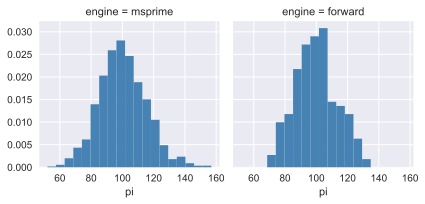

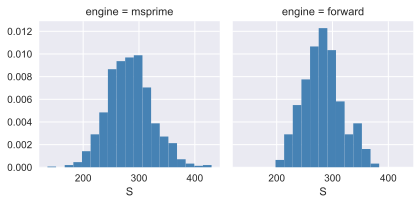

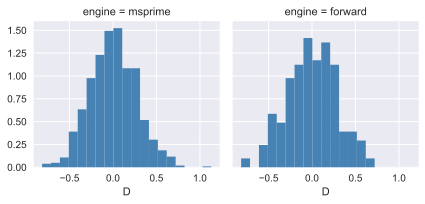

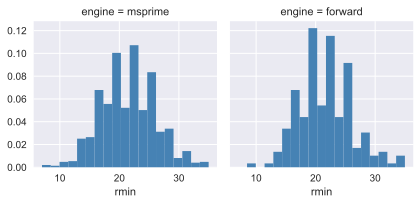

In [36]:
sns.set(style="darkgrid")
g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.pi.min(),summstats_df.pi.max(),20)
g.map(plt.hist,'pi',bins=bins,color="steelblue",lw=0,normed=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.S.min(),summstats_df.S.max(),20)
g.map(plt.hist,'S',bins=bins,color="steelblue",lw=0,normed=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.D.min(),summstats_df.D.max(),20)
g.map(plt.hist,'D',bins=bins,color="steelblue",lw=0,normed=True);

g = sns.FacetGrid(summstats_df,col="engine",margin_titles=True)
bins = np.linspace(summstats_df.rmin.min(),summstats_df.rmin.max(),20)
g.map(plt.hist,'rmin',bins=bins,color="steelblue",lw=0,normed=True);

In [38]:
from scipy.stats import ks_2samp

In [39]:
print(summstats_df.groupby(['engine']).agg(['mean','std']))

               S                     pi                    D            \
            mean        std        mean        std      mean       std   
engine                                                                   
forward  282.590  34.613035   99.951556  13.353636  0.003513  0.282005   
msprime  283.292  39.949402  100.258067  15.126211  0.005983  0.269245   

           hprime              rmin            
             mean       std    mean       std  
engine                                         
forward  0.013464  0.283872  21.765  4.565522  
msprime -0.006651  0.279047  21.515  4.662995  


In [40]:
ks_2samp(fwd_df.pi,msprime_df.pi)

Ks_2sampResult(statistic=0.042000000000000037, pvalue=0.92519139716992405)

In [41]:
ks_2samp(fwd_df.S,msprime_df.S)

Ks_2sampResult(statistic=0.07999999999999996, pvalue=0.22665283186099433)

In [42]:
ks_2samp(fwd_df.D,msprime_df.D)

Ks_2sampResult(statistic=0.044000000000000039, pvalue=0.89708454899602963)

In [43]:
ks_2samp(fwd_df.rmin,msprime_df.rmin)

Ks_2sampResult(statistic=0.058000000000000052, pvalue=0.6166875358737981)